### Solar Disaggregation Sensitivity Figures


In [3]:

import sys
sys.path.append("..") # Adds higher directory to python modules path.

import numpy as np
import pandas as pd
import csss
import sqlalchemy as sq
import matplotlib.pyplot as plt
import matplotlib
import pytz
import datetime as dt
import pickle as pk
from imp import reload
import copy


% matplotlib notebook
plt.rc('figure',dpi = 128)

In [4]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)


## Load Data
Load home and weather data, previously stored in Pickle files. 

Cursory plots shows that a some homes exhibit very correlated furnace and air conditioning energy use, possbily the use of fans in ducts. I may need to create a method for filtering out the furnace use that is associated with cooling. Possibly all heating use that is simultaneous with cooling is also cooling. 

There is also cooling consumption in February in some homes, it could be that the opposite is true, and for some homes fans are included on the air conditioning circuit. 

In [5]:
loaddata = pk.load(open('data/demand.pkl', 'rb'))
homeids = np.unique(loaddata['dataid'])
print('There are %d homes in the dataset' % len(homeids))

There are 200 homes in the dataset


In [6]:
## Make a heating and cooling column
loaddata['cooling'] = np.sum(loaddata[['air1','air2','air3','airwindowunit1']], axis = 1)
loaddata['heating'] = np.sum(loaddata[['furnace1','furnace2']], axis = 1)

In [7]:
loadgroup = loaddata[['dataid','use','gen','heating','cooling']].groupby("dataid")
loaddata_counts = loadgroup.count()
loaddata_means  = loadgroup.mean()
loaddata_counts.columns = ['count_' + d for d in loaddata_counts.columns]
loaddata_means.columns  = ['mean_' + d for d in loaddata_means.columns]
load_summary = pd.concat([loaddata_counts,loaddata_means], axis = 1)

In [8]:
load_summary = load_summary.loc[load_summary['count_use'] == np.max(load_summary['count_use']),:]

In [9]:
print('There are %d homes with complete data' % load_summary.shape[0])
print('%d homes solar' % np.sum(load_summary['count_gen']>0))
print('%d homes cooling' % np.sum(load_summary['count_cooling']>0))
print('%d homes heating' % np.sum(load_summary['count_heating']>0))

There are 89 homes with complete data
52 homes solar
82 homes cooling
63 homes heating


In [10]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

hours = mdates.HourLocator(interval = 3)   # locate every 3 hours
months = mdates.MonthLocator()  # every month
hoursFmt = mdates.DateFormatter('%H:%M')
dateFmt  = mdates.DateFormatter('%Y-%m-%d')



## Do a quick plot of load data
fig = plt.figure(figsize = (4,2))
first = True
ymin = 0
ymax = 0
axs = []
labels = 'ABCDEF'
l = 0
for xloc in [.1, .58]:
    ax = plt.axes([xloc,.28,.39,.6])

    dataid = np.random.choice(load_summary.index[load_summary['count_gen']>0], size=1)[0]

    data = loaddata.groupby('dataid').get_group(dataid)

    start = dt.datetime(2015,7,6)
    dur   = dt.timedelta(days = 1)
    ind = (data['local_15min'] > start) & (data['local_15min'] < start + dur)

    data = data.loc[ind,:]

    #ax.plot(data['local_15min'],-data['gen'], label = 'solar generation')

    ax.fill_between(np.array(data['local_15min']),data['use']*0,-data['gen'] , color = '#FFBB00', label = 'Solar')
    ax.plot(data['local_15min'],data['use'], label = 'Demand', color = 'blue', ls='dashed', lw=1 )
    ax.plot(data['local_15min'],data['use'], label = '__nolegend__', color = 'white', ls='solid', lw=3 )
    ax.plot(data['local_15min'],-data['gen'], label = '_nolegend_', color = '#AA3300', ls='solid', alpha = .5, lw=1 )
    ax.plot(data['local_15min'],data['use']-data['gen'], label = 'Net Load', color = 'black', lw=1)
    ax.plot(data['local_15min'],data['use'], label = '_nolegend_', color = 'blue', ls='dashed', lw=1 )

    if first:
        ax.legend(bbox_to_anchor=(.5,.86),
                 loc = 8,
                 bbox_transform=fig.transFigure,
                 ncol = 3,
                 frameon = False)
        ax.set_ylabel('Energy Consumption')
    first = False
    ax.set_xlabel('Time of day' + start.strftime(' on %a, %b %d') )#+ '\nSystem #' + str(dataid))

    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(hoursFmt)
    ax.xaxis.set_minor_locator(months)
    ax.annotate(labels[l], (.06, .83) , xycoords=ax.transAxes, fontsize=8)
    l+=1
    
    ymin = min(ymin,ax.get_ylim()[0])
    ymax = max(ymax,ax.get_ylim()[1])

    
    plt.xticks(rotation = 45)
    axs.append(ax)

for ax in axs:
    ax.set_ylim(ymin,ymax)
    
plt.show()
fig.savefig('figures/dataexample.png', dpi = 900)

<IPython.core.display.Javascript object>

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


## Climate Data
Load Appropriate Climate Data from Pecan Street.  There is no way to identify which homes belong to which datase.  There are only three locations, I'll pull all of them. 

In [11]:
weather = pk.load(open('data/weather.pkl', 'rb'))
weather.head()

localhour   latitude   longitude  tz_offset summary  \
0  2015-08-23 13:00:00-05:00  40.027278 -105.256111         -6   Clear   
1  2015-09-06 03:00:00-05:00  40.027278 -105.256111         -6   Clear   
2  2015-09-25 22:00:00-05:00  40.027278 -105.256111         -6   Clear   
3  2015-09-25 23:00:00-05:00  40.027278 -105.256111         -6   Clear   
4  2015-09-26 10:00:00-05:00  40.027278 -105.256111         -6   Clear   

    ozone ozone_error  temperature temperature_error  dew_point    ...     \
0  287.11        None        67.27              None      41.72    ...      
1  276.72        None        65.97              None      43.65    ...      
2  263.95        None        63.46              None      41.04    ...      
3  262.46        None        61.34              None      41.05    ...      
4  248.03        None        60.14              None      39.87    ...      

  wind_speed  wind_speed_error cloud_cover  cloud_cover_error wind_bearing  \
0       2.15              None        0.13               None           66   
1       2.05              None        0.07               None          269   
2       0.89              None        0.00               None          160   
3       0.68              None        0.00               None          220   
4       0.32              None        0.00               None           43   

   precip_intensity precip_intensity_error  precip_probability precip_type  \
0               0.0                   None                 0.0        None   
1               0.0                   None                 0.0        None   
2               0.0                   None                 0.0        None   
3               0.0                   None                 0.0        None   
4               0.0                   None                 0.0        None   

   Location  
0   Boulder  
1   Boulder  
2   Boulder  
3   Boulder  
4   Boulder  

[5 rows x 29 columns]

## Create Weather Regressors

In [12]:
def createTempInput(temp, size, minTemp=None, maxTemp=None, intercept = False):
    if (minTemp is None):
        minTemp=min(temp)
    if maxTemp is None:
        maxTemp=max(temp)
    minBound=int(np.floor(minTemp / size)) * size
    maxBound=int(np.floor(maxTemp / size)) * size + size
    rangeCount=int((maxBound-minBound) / size)
    result=[]
    for elem in temp:
        fullRanges = min( int(np.floor((elem-minBound) / size)), rangeCount-1)
        bound      = (minBound+fullRanges*size)
        lastRange  = elem-bound
        res        = [size for elem in range(fullRanges)]
        res.append(lastRange)
        for var in range(rangeCount-fullRanges-1):
            res.append(0)
        if intercept:
            res.append(1)  ## Include an intercept
        result.append(res)
    return minBound, maxBound,result


weatherAustin = weather.groupby("Location").get_group("Austin").sort_values("localhour")
weatherAustin['utctime'] = pd.to_datetime(weatherAustin['localhour'], utc = True)
#weatherAustin['time'] = weatherAustin['localhour']
#weatherAustin["time"] = weatherAustin.set_index("localhour").index.tz_localize(pytz.utc, ambiguous = False)
weatherAustin = weatherAustin.set_index("localhour")



In [13]:
weatherAustin[['utctime']]
loaddata['utctime'] = pd.to_datetime(loaddata['time'], utc = True)

In [14]:
tmin, tmax, tempregress = createTempInput(weatherAustin['temperature'],10)
np.array(tempregress).shape

(8761, 9)

### Set up an example Solar Disaggregation on multiple homes

## Create the individual homes model
This code creates the CSSS model for disaggregating solar at individual homes. 
This is the training problem, not the real time problem. 
See note below on issues with values of alpha. 

### Alpha and solver errors
The solver is sensitive to large values of alpha, particularly with more data.  There seems to be an inverse relationship between the maximum size of alpha and the amount of data. The errors scale with t he magnitude of alpha, not the difference between alphas, so by scaling the maximum alpha to 1, we may solve this problem. 

## Sensitivity Cases
- Pre and post tuning
- fraction feed-in (defined by system)
- Ndays (randomly chosen days)
- Nproxies (randomly chosen systems)
- Ntunesys (randomly chosen systems)

Steady case: 8 homes, 2 proxies, 10 days of readings, randomly sampled, 2 tuning systems. 

In [15]:
def run_scenario(Nhomes, Nproxies, Ndays, Ntunesys, Nsolar):
    ## Identify dataids to use
    dataids  = np.random.choice( load_summary.index[load_summary['count_gen']>0] , Nhomes+Nproxies, replace=False)
    proxyids = dataids[:Nproxies]   # Homes to be used as solar proxy
    homeids  = dataids[Nproxies:]    # Homes to be used for disaggregation
    tuneids  = homeids[:Ntunesys]  # Home to be used for tuning
    solids   = homeids[:Nsolar]    # homes with solar. 

    ## Set up data 
    first = True
    for did in dataids:
        dat = loaddata.groupby("dataid").get_group(did).set_index('time')[['use','gen']]
        if did in np.concatenate([proxyids,solids]):
            dat['gen'] = -dat['gen']
        else:
            dat['gen'] = 0
        dat['netload_%s' % did] = dat['use'] + dat['gen']
        dat.columns = ['demand_%s' % did, 'solar_%s' % did, 'netload_%s' % did]

        if first:
            fulldata = dat
            first = False
        else:
            fulldata = pd.concat([fulldata,dat], axis = 1)

    ## Create aggregate load and aggregate net load columns. 
    netloadcols = ['netload_%s' % d for d in homeids]
    loadcols    = ['demand_%s' %  d for d in homeids]
    proxycol    = ['solar_%s' %   d for d in proxyids]

    fulldata['AggregateNetLoad'] = np.sum(fulldata[netloadcols], axis = 1)
    fulldata['AggregateLoad']    = np.sum(fulldata[loadcols], axis = 1)
    fulldata['Date'] = [dt.datetime(t.year, t.month, t.day, 0, 0, 0) for t in fulldata.index]
        
    ## Time align weather data with load data using linear interpolation 
    xp  = [t.value for t in weatherAustin['utctime']  ]
    x = [t.value for t in pd.to_datetime(fulldata.index, utc = True)  ]
    fulldata['AustinTemp'] = np.interp(x = x ,xp=xp, fp =  weatherAustin['temperature'])

    ## Get indices for Ndays random dates
    dates = fulldata[['Date','AggregateLoad']].groupby('Date').count()   ### Find number of readings for each date
    numel = dates['AggregateLoad']                                      
    dates = dates.index[numel == np.max(numel)]                          ### Choose only dates with complete readings
    dates = dates[ np.random.choice(np.arange(len(dates)), replace=False, size=Ndays) ] ### Randomly select Ndays dates
    induse = fulldata['Date'].isin(dates)  ### Subset data
    data = fulldata.loc[induse,:]

    ## Get HOD regressors
    hod = pd.Series([t.hour for t in data.index])
    hod = pd.get_dummies(hod)

    ## Get temperature regressors
    Tmin, Tmax, tempregress = regressor=createTempInput(data['AustinTemp'], 10)

    ## Prepare data for ingestion into SolarDisagg method. 
    loadregressors = np.hstack([hod,tempregress])
    tuningregressors = np.array(hod)
    netload = np.array(data[netloadcols])
    solarproxy = np.array(data[proxycol])
    names = ['solar_%s' % d for d in homeids]

    ## Construct solar disaggregation problem
    reload(csss.SolarDisagg)
    sdmod0 = csss.SolarDisagg.SolarDisagg_IndvHome(netloads=netload, solarregressors=solarproxy, 
                                                   loadregressors=loadregressors, tuningregressors=tuningregressors,
                                                   names = names)


    ## add true vectors
    for d in homeids:
        source_name = 'solar_%s' % d
        sdmod0.addTrueValue(name=source_name, trueValue=data[source_name])

    ## Add true aggregate load
    sdmod0.addTrueValue(name = 'AggregateLoad', trueValue=data['AggregateLoad'])

    ## Construct and solve the problem. 
    sdmod0.constructSolve()
    sdmod_tune = copy.deepcopy(sdmod0)
    sdmod_tune.fitTuneModels(['solar_%s' % d for d in tuneids])
    sdmod_tune.tuneAlphas()
    sdmod_tune.constructSolve()
    
    outdict = {}
    outdict['tuned_model'] = sdmod_tune
    outdict['initial_model'] = sdmod0
    outdict['dates'] = dates
    outdict['times'] = data.index
    outdict['proxyids'] = proxyids
    outdict['homeids']  = homeids
    outdict['tuneids']  = tuneids
    outdict['data']     = data
    return(outdict)


scen_out = run_scenario(8,3,10,2,4)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [16]:
## Create figure of weather regressors
data = scen_out['data']

start = scen_out['dates'][6]
start = pytz.timezone('America/Chicago').localize(start)
hoursFmt = mdates.DateFormatter('%H:%M', tz = pytz.timezone('America/Chicago'))
dateFmt  = mdates.DateFormatter('%Y-%m-%d')


dur   = dt.timedelta(days = 2)
ind = (data.index > start) & (data.index < start + dur)

wdata = data.loc[ind,:]


fig = plt.figure(figsize = (5,3))
ax1 = plt.axes([.15, .65, .8, .30])
ax1.plot(wdata.index, wdata['AustinTemp'], 'k-', lw = 3, label = 'Temperature')
ax1.set_xticks([None])
#ax1.legend(loc = 2)
ax1.set_ylabel('Temperature')
ax1.annotate('A', (.03, .73) , xycoords=ax1.transAxes, fontsize=18)


minb, maxb, result = createTempInput(wdata['AustinTemp'], 10)
temp_regressor = np.matrix(result)


ax2 = plt.axes([.15, .18, .8, .28])
styles = ['-' , '--' , '-.' , ':','-']
colors = ['gray','red','blue','black','pink']
for i in range(temp_regressor.shape[1]):
    ax2.plot(wdata.index, temp_regressor[:,i], 
             lw = 3, 
             label = str(minb + 10*i) + 'F',
             ls = styles[i],
             color = colors[i])
plt.xticks(rotation = 20)
ax2.xaxis.set_major_formatter(hoursFmt)
ax2.legend(bbox_to_anchor=(.5,.85),
         loc = 8,
         bbox_transform=ax2.transAxes,
         ncol = temp_regressor.shape[1],
         frameon = False)
ax2.annotate('Regressors, by lower bound temperature',(.1,1.30),
             xycoords=ax2.transAxes,
             fontsize = 11)
ax2.set_ylim(-1,11)
ax2.set_xlabel('Time of day' + start.strftime(' on %a, %b %d'))
ax2.set_ylabel('Regressor \nValue')
ax2.annotate('B', (.03, .73) , xycoords=ax2.transAxes, fontsize=18)



plt.show()

fig.savefig('figures/temperatureRegressors.png')

<IPython.core.display.Javascript object>

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [20]:
## Create table of performance metrics. 
sdmod0.calcPerformanceMetrics()
sdmod1.calcPerformanceMetrics()

met_1 = sdmod0.performanceMetrics.sort_index(ascending=False)[['mean','rmse','mbe']]
met_2 = sdmod1.performanceMetrics.sort_index(ascending=False)[['rmse','mbe']]
met_2['alpha'] = np.nan

for name, m in sdmod1.models.items():
    met_2.loc[name,'alpha'] = np.mean(m['alpha'])
    
met = pd.concat([met_1,met_2], axis = 1)

print(round(met,2).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  mean &  rmse &   mbe &  rmse &   mbe &  alpha \\
models        &       &       &       &       &       &        \\
\midrule
solar\_9932    &  0.00 &  0.55 &  0.40 &  0.10 &  0.05 &   0.42 \\
solar\_93      &  0.00 &  0.55 &  0.40 &  0.10 &  0.05 &   0.23 \\
solar\_6643    &  0.00 &  0.55 &  0.40 &  0.10 &  0.06 &   0.19 \\
solar\_4297    & -0.50 &  0.37 &  0.25 &  0.15 &  0.06 &   0.28 \\
solar\_3849    & -0.78 &  0.47 &  0.25 &  0.54 &  0.19 &   0.15 \\
solar\_3723    &  0.00 &  0.55 &  0.40 &  0.10 &  0.05 &   0.25 \\
solar\_3456    & -0.77 &  0.34 &  0.15 &  0.15 &  0.00 &   0.29 \\
solar\_2470    & -0.45 &  0.37 &  0.23 &  0.29 &  0.10 &   0.36 \\
AggregateLoad &  7.19 &  3.42 & -2.50 &  1.23 & -0.57 &   0.00 \\
\bottomrule
\end{tabular}



<IPython.core.display.Javascript object>


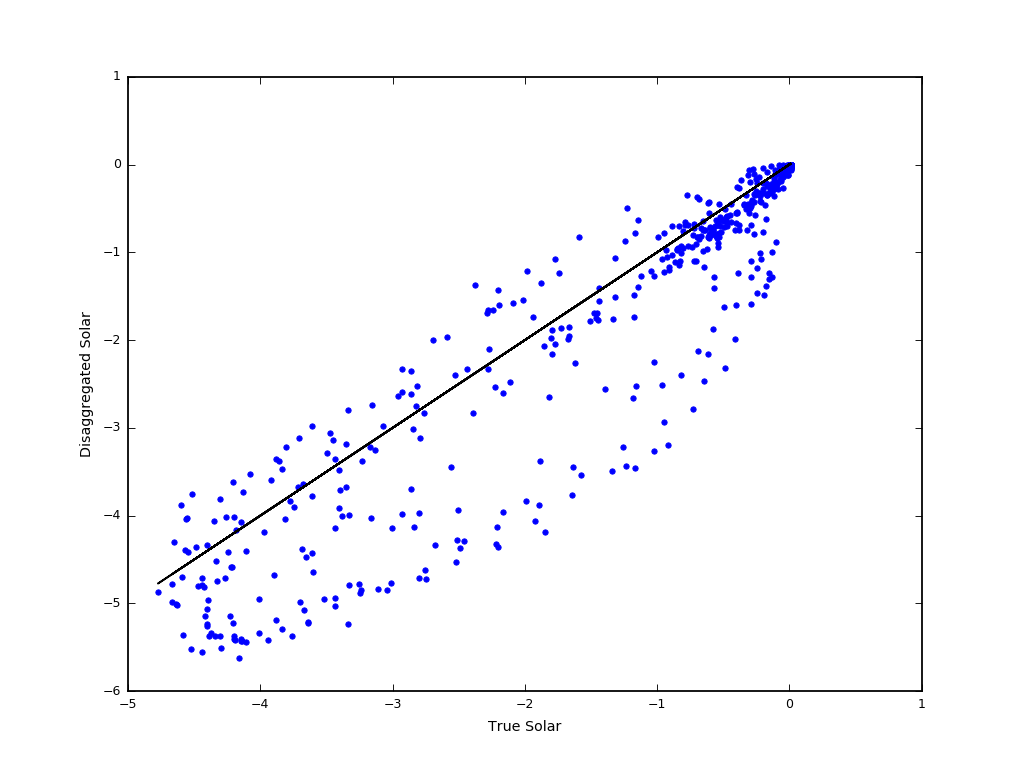

<IPython.core.display.Javascript object>


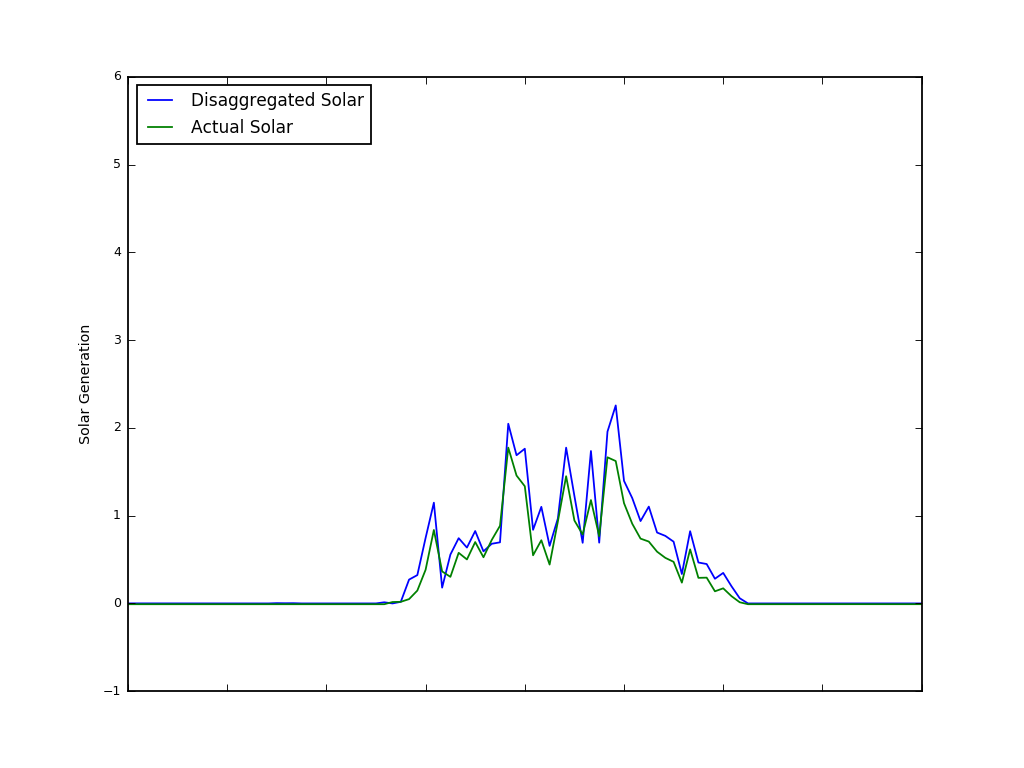

<IPython.core.display.Javascript object>


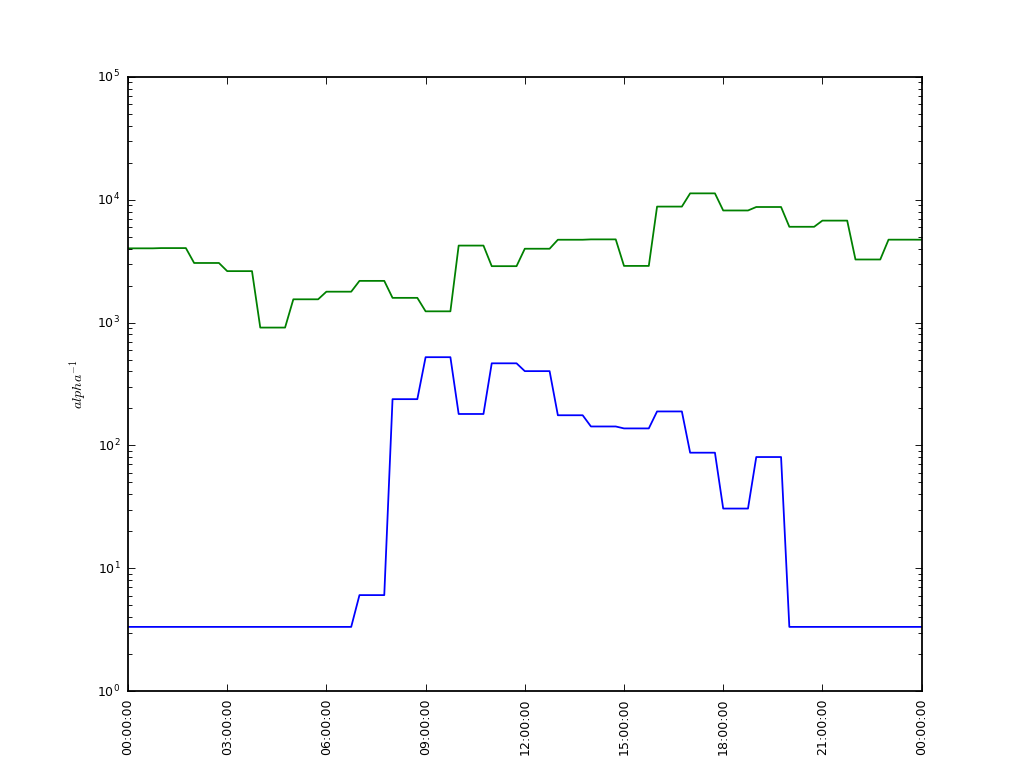

(735893.2083333334, 735894.2083333334)

In [21]:
sdmod = scen_out['initial_model']
sdmod = scen_out['tuned_model']
i=3
source_name = sdmod.names[i]
fig = plt.figure()
ax = plt.gca()
ax.plot(sdmod.trueValues[source_name],  sdmod.models[source_name]['source'].value, '.')
ax.plot(sdmod.trueValues[source_name],  sdmod.trueValues[source_name], 'k-')
ax.set_xlabel('True Solar')
ax.set_ylabel('Disaggregated Solar')

fig = plt.figure()
ax = plt.gca()
ax.plot(scen_out['times'],  -sdmod.models[source_name]['source'].value, '-', label = 'Disaggregated Solar')
ax.plot(scen_out['times'],  -sdmod.trueValues[source_name], '-', label = 'Actual Solar')

start = scen_out['dates'][1]
dur   = dt.timedelta(days = 1)
start = pytz.timezone('America/Chicago').localize(start)
ax.legend(loc = 2)
ax.set_ylabel('Solar Generation')
ax.set_xticklabels([])
ax.set_xlim(start, start + dur)
#ax.set_title((start, source_name))

fig = plt.figure()
ax = plt.gca()
alpha_inv = (sdmod.models[source_name]['alpha'])**-1
alpha_load_inv = (sdmod.models['AggregateLoad']['alpha'])**-1
ax.semilogy(scen_out['times'], alpha_inv, '-', label = r'$\alpha^{-1}$')
ax.semilogy(scen_out['times'], alpha_load_inv, '-', label = r'$\alpha^{-1}$')
ax.set_ylabel(r'$alpha^{-1}$')

plt.xticks(rotation = 90)
ax.set_xlim(start, start + dur)

<IPython.core.display.Javascript object>


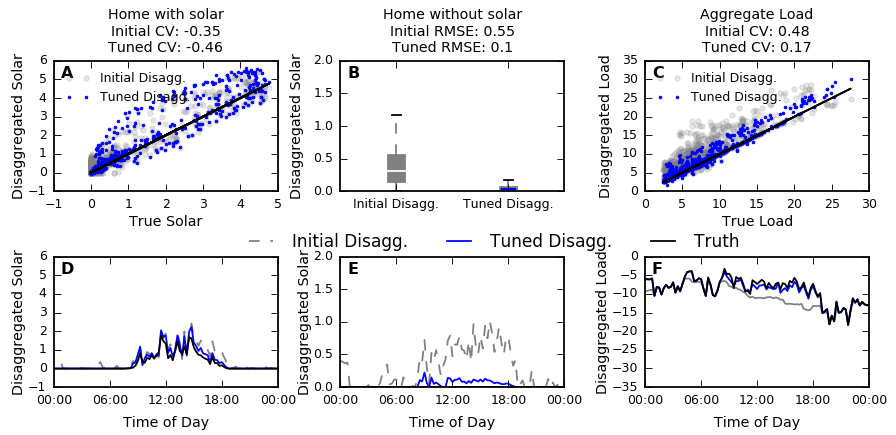

<IPython.core.display.Javascript object>


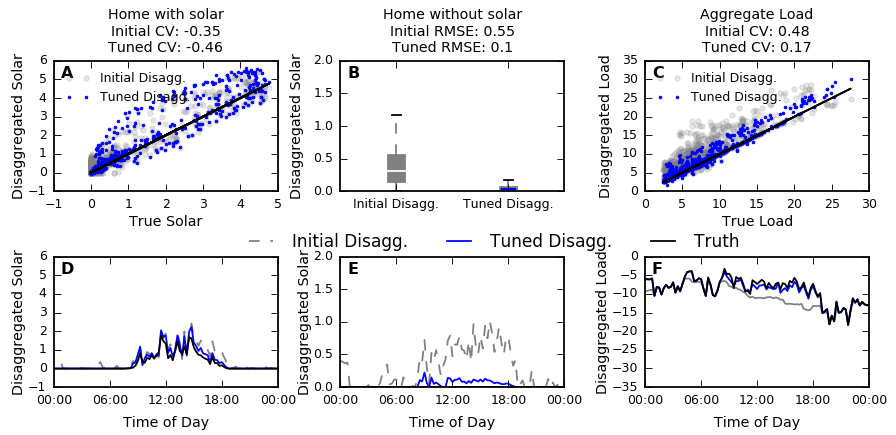

In [23]:
## Create descriptive figure for paper. 
# 6 panels. 
# Row 1, predicted values versus actual values, plot tuned and untuned results on the same plot

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 8}


matplotlib.rc('font', **font)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('axes',titlesize=8)


sdmod0 = scen_out['initial_model']
sdmod1 = scen_out['tuned_model']

i=3
source_name = sdmod.names[i]
fig = plt.figure(figsize = (7,3.4))
ax11 = plt.axes([.06, .56, .25, .3])
ax11.plot(-sdmod0.trueValues[source_name],  -sdmod0.models[source_name]['source'].value, 'o', markersize = 3, 
          mfc = 'gray', mec = 'gray', alpha = .2, label = 'Initial Disagg.')
ax11.plot(-sdmod1.trueValues[source_name],  -sdmod1.models[source_name]['source'].value, '.', markersize = 3,
          mfc = 'b', mec = 'b', label = 'Tuned Disagg.')
ax11.plot(-sdmod0.trueValues[source_name],  -sdmod0.trueValues[source_name], 'k-', label = '_nolegend_')
ax11.legend(loc = 2, frameon = False, fontsize = 7)
ax11.set_xlabel('True Solar', labelpad=2)
ax11.set_ylabel('Disaggregated Solar', labelpad=1)
ax11.set_title('Home with solar\nInitial CV: %.2g\nTuned CV: %.2g' % 
               (sdmod0.performanceMetrics.loc[source_name,'cv_pos'], 
                sdmod1.performanceMetrics.loc[source_name,'cv_pos']))
ax11.annotate('A', (.03, .87) , xycoords=ax11.transAxes, fontsize=9, fontweight = 'bold')


i=6
source_name = sdmod.names[i]
ax12 = plt.axes([.38, .56, .25, .3])
bplot = ax12.boxplot([-1 * np.array(sdmod0.models[source_name]['source'].value).squeeze(), 
                      -1 * np.array(sdmod1.models[source_name]['source'].value).squeeze()], 
                     labels=['Initial Disagg.','Tuned Disagg.'],
                    boxprops = {'color':'grey'},
                    whiskerprops = {'color':'grey'},
                    medianprops = {'color':'white'},
                    flierprops = {'markerfacecolor':'grey','markeredgecolor':'none','markersize':2},
                    patch_artist=True)
#ax12.plot(sdmod1.trueValues[source_name],  sdmod1.models[source_name]['source'].value, '.', mfc = 'b', mec = 'b', label = 'Tuned Model')
#ax12.plot(sdmod0.trueValues[source_name],  sdmod0.trueValues[source_name], 'k-', label = '_nolegend_')
ax12.set_ylabel('Disaggregated Solar')
ax12.set_title('Home without solar\nInitial RMSE: %.2g\nTuned RMSE: %.2g' % (met_1.loc[source_name,'rmse'], met_2.loc[source_name,'rmse']))
ax12.annotate('B', (.03, .87) , xycoords=ax12.transAxes, fontsize=9, fontweight = 'bold')

colors = ['gray', 'blue']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)


ax13 = plt.axes([.72, .56, .25, .3])
source_name = 'AggregateLoad'
ax13.plot(sdmod0.trueValues[source_name],  sdmod0.models[source_name]['source'].value, 'o', markersize = 3,
          mfc = 'gray', mec = 'gray', alpha = .2, label = 'Initial Disagg.')
ax13.plot(sdmod1.trueValues[source_name],  sdmod1.models[source_name]['source'].value, '.', markersize = 3,
          mfc = 'b', mec = 'b', label = 'Tuned Disagg.')
ax13.plot(sdmod0.trueValues[source_name],  sdmod0.trueValues[source_name], 'k-', label = '_nolegend_')
ax13.legend(loc = 2, frameon = False, fontsize = 7)
ax13.set_title('Aggregate Load\nInitial CV: %.2g\nTuned CV: %.2g' % 
               (sdmod0.performanceMetrics.loc[source_name,'cv_pos'], 
                sdmod1.performanceMetrics.loc[source_name,'cv_pos']))
ax13.set_xlabel('True Load', labelpad=2)
ax13.set_ylabel('Disaggregated Load')
ax13.annotate('C', (.03, .87) , xycoords=ax13.transAxes, fontsize=9, fontweight = 'bold')


## Time series plots of truth and disaggregated output. 
start = scen_out['dates'][1]
dur   = dt.timedelta(days = 1)
start = pytz.timezone('America/Chicago').localize(start)
hours = mdates.HourLocator(interval = 6)   # locate every 3 hours


i=3
source_name = sdmod.names[i]
ax21 = plt.axes([.06, .11, .25, .3])
ax21.plot(scen_out['times'],  -sdmod0.models[source_name]['source'].value, '--', color = 'gray', label = 'Initial Disagg.')
ax21.plot(scen_out['times'],  -sdmod1.models[source_name]['source'].value, '-', color = 'blue', label = 'Tuned Disagg.')
ax21.plot(scen_out['times'],  -sdmod0.trueValues[source_name], 'k-', label = 'Truth')
#ax21.legend(loc = 2, frameon = False)
ax21.set_xlabel('Time of Day')
ax21.set_ylabel('Disaggregated Solar', labelpad=1)
ax21.set_xlim(start, start + dur)
ax21.xaxis.set_major_formatter(hoursFmt)
ax21.xaxis.set_major_locator(hours)
ax21.annotate('D', (.03, .87) , xycoords=ax21.transAxes, fontsize=9, fontweight = 'bold')


i=6
source_name = sdmod.names[i]
ax22 = plt.axes([.38, .11, .25, .3])
ax22.plot(scen_out['times'],  -sdmod0.models[source_name]['source'].value, '--', color = 'gray', label = 'Initial Disagg.')
ax22.plot(scen_out['times'],  -sdmod1.models[source_name]['source'].value, '-', color = 'blue', label = 'Tuned Disagg.')
ax22.plot(scen_out['times'],  -sdmod0.trueValues[source_name], 'k-', label = 'Truth')
ax22.legend(bbox_to_anchor=(-.5, 1.3),
         loc = 2,
         bbox_transform=ax22.transAxes,
         ncol = 3,
         frameon = False)
ax22.set_xlabel('Time of Day')
ax22.set_ylabel('Disaggregated Solar', labelpad=1)
ax22.set_xlim(start, start + dur)
ax22.xaxis.set_major_formatter(hoursFmt)
ax22.xaxis.set_major_locator(hours)
ax22.annotate('E', (.03, .87) , xycoords=ax22.transAxes, fontsize=9, fontweight = 'bold')



ax23 = plt.axes([.72, .11, .25, .3])
source_name = 'AggregateLoad'
ax23.plot(scen_out['times'],  -sdmod0.models[source_name]['source'].value, '-', color = 'gray', label = 'Initial Disagg.')
ax23.plot(scen_out['times'],  -sdmod1.models[source_name]['source'].value, '-', color = 'blue', label = 'Tuned Disagg.')
ax23.plot(scen_out['times'],  -sdmod0.trueValues[source_name], 'k-', label = 'Truth')
#ax23.legend(loc = 3, frameon = False)
ax23.set_xlabel('Time of Day')
ax23.set_ylabel('Disaggregated Load', labelpad=1)
ax23.set_xlim(start, start + dur)
ax23.xaxis.set_major_formatter(hoursFmt)
ax23.xaxis.set_major_locator(hours)
ax23.annotate('F', (.03, .87) , xycoords=ax23.transAxes, fontsize=9, fontweight = 'bold')



fig.savefig('figures/descriptiveExample.png', dpi = 400)
fig

<IPython.core.display.Javascript object>


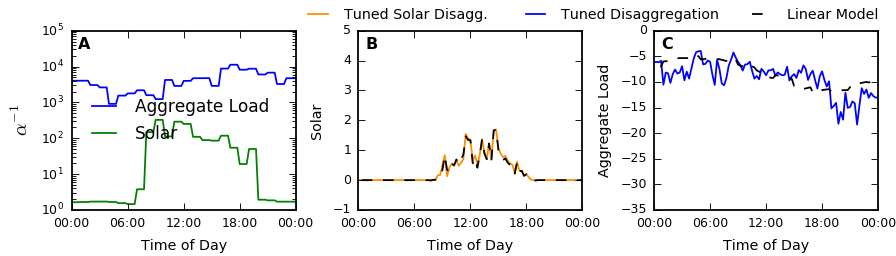

In [25]:
## Create 3 panel descriptive figure 
fig = plt.figure(figsize = (7,2))


i=2
source_name = sdmod.names[i]

ax = plt.axes([.08, .18, .25, .7])
alpha_inv = (sdmod1.models[source_name]['alpha'])**-1
alpha_load_inv = (sdmod1.models['AggregateLoad']['alpha'])**-1
ax.semilogy(scen_out['times'], alpha_load_inv, '-',  label = 'Aggregate Load')
ax.semilogy(scen_out['times'], alpha_inv, '-',  label = 'Solar')
ax.set_ylabel(r'$\alpha^{-1}$', fontsize = 11)
ax.legend(loc = 6, frameon = False)
ax.set_xlabel('Time of Day')

ax.set_xlim(start, start + dur)
ax.xaxis.set_major_formatter(hoursFmt)
ax.xaxis.set_major_locator(hours)
ax.annotate('A', (.03, .9) , xycoords=ax.transAxes, fontsize=9, fontweight = 'bold')


ax21 = plt.axes([.40, .18, .25, .7])
lin_pred = (sdmod1.models[source_name]['regressor'] * sdmod1.models[source_name]['theta']).value
ax21.plot(scen_out['times'],  -sdmod1.models[source_name]['source'].value, '-', color = 'darkorange',
          label = 'Tuned Solar Disagg.')
ax21.plot(scen_out['times'],  -lin_pred,                                   '--', color = 'k', 
          label = '__nolegend__', lw = 1)
ax21.legend(loc = 2, frameon = False, ncol = 2, 
            bbox_transform=ax21.transAxes, bbox_to_anchor = (-.3, 1.2), fontsize = 8)
ax21.set_xlabel('Time of Day')
ax21.set_ylabel('Solar')
ax21.set_xlim(start, start + dur)
ax21.xaxis.set_major_formatter(hoursFmt)
ax21.xaxis.set_major_locator(hours)
ax21.annotate('B', (.03, .9) , xycoords=ax21.transAxes, fontsize=9, fontweight = 'bold')

i=3
source_name = 'AggregateLoad'
ax21 = plt.axes([.73, .18, .25, .7])
lin_pred = (sdmod1.models[source_name]['regressor'] * sdmod1.models[source_name]['theta']).value
ax21.plot(scen_out['times'],  -sdmod1.models[source_name]['source'].value, '-', color = 'blue', label = 'Tuned Disaggregation')
ax21.plot(scen_out['times'],  -lin_pred,                                   '--', 
          color = 'k', label = 'Linear Model', lw = 1)
ax21.legend(loc = 2, frameon = False, ncol = 2, fontsize = 8,
            bbox_transform=ax21.transAxes, bbox_to_anchor = (-.65, 1.2))
ax21.set_xlabel('Time of Day')
ax21.set_ylabel('Aggregate Load')
ax21.set_xlim(start, start + dur)
ax21.xaxis.set_major_formatter(hoursFmt)
ax21.xaxis.set_major_locator(hours)
ax21.annotate('C', (.03, .9) , xycoords=ax21.transAxes, fontsize=9, fontweight = 'bold')


fig.savefig('figures/tuningExplanation.pdf')